## A Spatio-Temporal Accessibility Analysis of Pharmacy Care in Vermont, USA
---

Extends and adapts studies *by* Kang, J. Y., A. Michels, F. Lyu, Shaohua Wang, N. Agbodo, V. L. Freeman, and Shaowen Wang. 2020. Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA. International Journal of Health Geographics 19 (1):1–17. DOI:[10.1186/s12942-020-00229-x](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/s12942-020-00229-x) AND Holler, J., Burt, D., Udoh, K., & Kedron, P. (2022). Reproduction and Reanalysis of Kang et al 2020 Spatial Accessibility of COVID-19 Health Care Resources. https://doi.org/10.17605/OSF.IO/N92V3



Authors: Sam Roubin, Joseph Holler, Peter Kedron

Reproduction Materials Available at: https://github.com/samroubin/VTPharmacy/tree/main

Created: `2024-01-14`
Revised: `2023-01-`

### Original Data
To perform the ESFCA method, three types of data are required, as follows: (1) road network, (2) population, and (3) pharmacy information. The road network can be obtained from the [OpenStreetMap Python Library, called OSMNX](https://github.com/gboeing/osmnx). The population data is available from the US Census Bureau on the [American Community Survey]. Lastly, hospital information available on our GitHub repository: 

### Modules
Import necessary libraries to run this model.
See `environment.yml` for the library versions used for this analysis.

In [2]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
import re
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import folium
import itertools
import os
import time
import warnings
import IPython
import requests
from IPython.display import display, clear_output
from shapely.ops import nearest_points   #for hospital_setting function

warnings.filterwarnings("ignore")
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.0
pandas==1.3.5
geopandas==0.10.2
networkx==2.6.3
osmnx==1.1.2
re==2.2.1
folium==0.12.1.post1
IPython==8.3.0
requests==2.27.1


## Check Directories


In [3]:
# Check working directory
os.getcwd()

'/home/jovyan/work/VTPharmacy/procedure/code'

In [4]:
# Use to set work directory properly
if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../../')
os.getcwd()

'/home/jovyan/work/VTPharmacy'

## Load and Visualize Data

### Population by town for all states in study area (VT, NH, MA, NY)

In [6]:
# Read in population data by town
population_df = gpd.read_file('./data/raw/public/population/tidycensus_population.gpkg')
population_df.head()


# Read in metropolitan / micropolitan classifications (NECTAS)
nectas_df =  gpd.read_file('./data/raw/public/population/nectas.csv')
nectas_df.head()


# Join NECTAS classifications to population data with subdivision and county FIPS
pop_df = pd.merge(population_df, nectas_df[['fips_subdivision', 'necta', 'fips_county', 'fips_state']], on=['fips_subdivision','fips_county', 'fips_state'], how = 'left')
pop_df.head()

# Save as geopackage into public/derived



,GEOID,fips_state,fips_county,fips_subdivision,subdivision_name,total_pop,elderly_pop,pct_elderly,geometry,necta
0,5001773675,50,017,73675,"Tunbridge town, Orange County, Vermont",1337.0,189.0,14.136126,"POLYGON ((494016.737 152571.233, 494092.504 15...",NaN
1,5000975175,50,009,75175,"Victory town, Essex County, Vermont",70.0,19.0,27.142857,"POLYGON ((546966.722 227691.457, 547619.988 22...",NaN
2,5000902162,50,009,02162,"Avery's gore, Essex County, Vermont",0.0,0.0,NaN,"POLYGON ((551630.172 271974.320, 556994.743 27...",NaN
3,5000159650,50,001,59650,"Ripton town, Addison County, Vermont",739.0,145.0,19.621110,"POLYGON ((454852.030 171483.437, 457345.808 17...",NaN
4,5000108575,50,001,08575,"Bridport town, Addison County, Vermont",1225.0,284.0,23.183673,"POLYGON ((426786.611 165125.435, 426899.753 16...",NaN


<AxesSubplot:>

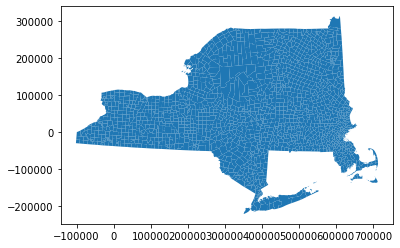

In [7]:
pop_df.plot()

### Load Pharmacy Data

This data contains the hours of operations and the number of pharmacists and pharmacy technicians staffed at each pharmacy

In [8]:
# Read in pharmacy data
pharmacies = gpd.read_file('./data/raw/private/pharmacies_final.gpkg')
pd.set_option('display.max_rows', None)
pharmacies.head()

,pharmid,pharmacy_name,type,address,state,lat,lon,week_open,week_close,week_pharm,week_tech,sat_open,sat_close,sat_pharm,sat_tech,sun_open,sun_close,sun_pharm,sun_tech,geometry
0,VT1,The Pharmacy Inc,independent,"205 North St, Bennington, VT",VT,42.881931,-73.196657,9:00:00,18:00:00,3.0,5.0,9:00:00,15:00:00,1.0,2.0,Closed,Closed,NaN,NaN,POINT (-73.19666 42.88193)
1,VT2,Kinney Drugs #18,chain,"164 Swanton Road, St. Albans, VT 05478",VT,44.835696,-73.080982,8:00:00,20:00:00,2.0,5.0,9:00:00,18:00:00,1.0,2.0,9:00:00,16:00:00,1.0,2.0,POINT (-73.08098 44.83570)
2,VT3,Corner Drug Co,independent,"213 Maple St, White River Junction, VT 05001",VT,43.652298,-72.318720,9:00:00,18:00:00,1.0,2.0,9:00:00,15:00:00,1.0,2.0,Closed,Closed,NaN,NaN,POINT (-72.31872 43.65230)
3,VT4,Kinney Drugs #21,chain,"82 Pearl Street, Essex Junction, VT 05452",VT,44.493619,-73.120292,9:00:00,19:00:00,1.0,3.0,9:00:00,18:00:00,1.0,1.0,9:00:00,16:00:00,1.0,1.0,POINT (-73.12029 44.49362)
4,VT5,Kinney Drugs #11,chain,"800 Us Route 302, Barre, VT 05641",VT,44.221775,-72.545779,9:00:00,20:00:00,2.0,3.0,9:00:00,18:00:00,1.0,3.0,9:00:00,16:00:00,1.0,3.0,POINT (-72.54578 44.22178)


### Fill in missing staffing data

In [47]:
pharmacies = 
# Make all 

SyntaxError: invalid syntax (1065354953.py, line 1)

### Generate and Plot Map of Pharmacies

In [9]:
pharmacies.explore()

### Load the Road Network

If `Vermont_Network_Buffer.graphml` does not already exist, this cell will query the road network from OpenStreetMap.  

Each of the road network code blocks may take a few mintues to run.

In [13]:
%%time

# To create a new graph from OpenStreetMap, delete or rename data/raw/private/Vermont_Network_Buffer.graphml
# (if it exists), and set OSM to True
OSM = True

# Define the place name for Vermont
place_name_vermont = 'Vermont, USA'

# if buffered street network is not saved, and OSM is preferred, generate a new graph from OpenStreetMap and save it
if not os.path.exists("./data/raw/private/Vermont_Network_Buffer_20mi.graphml") and OSM:
    print("Loading buffered Vermont road network from OpenStreetMap. Please wait... runtime may exceed 9min...", flush=True)
    G = ox.graph_from_place('Vermont', network_type='drive', buffer_dist=32186.8) 
    print("Saving Vermont road network to raw/private/Vermont_Network_Buffer_20mi.graphml. Please wait...", flush=True)
    ox.save_graphml(G, './data/raw/private/Vermont_Network_Buffer_20mi.graphml')
    print("Data saved.")
    
# otherwise, if buffered street network is not saved, download graph from the OSF project
# elif not os.path.exists("./data/raw/private/Vermont_Network_Buffer.graphml"):
#     print("Downloading buffered Vermont road network from OSF...", flush=True)
#     url = 'https://osf.io/download/65a6bf5aa246ff0cd5dd3ee8/'  
#     r = requests.get(url, allow_redirects=True)
#     print("Saving buffered Vermont road network to file...", flush=True)
#     open('./data/raw/private/Vermont_Network_Buffer.graphml', 'wb').write(r.content)
    
# # load the saved network graph
# if os.path.exists("./data/raw/private/Vermont_Network_Buffer.graphml"):
#     print("Loading buffered Vermont road network from raw/private/Vermont_Network_Buffer.graphml. Please wait...", flush=True)
#     G = ox.load_graphml('./data/raw/private/Vermont_Network_Buffer.graphml') 
#     print("Data loaded.") 
# else:
#     print("Error: could not load the road network from file.")

Loading buffered Vermont road network from OpenStreetMap. Please wait... runtime may exceed 9min...
Saving Vermont road network to raw/private/Vermont_Network_Buffer_20mi.graphml. Please wait...
Data saved.
CPU times: user 10min 35s, sys: 28 s, total: 11min 3s
Wall time: 46min 33s


### Plot the Road Network

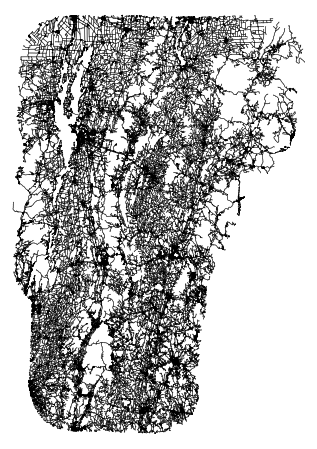

CPU times: user 33.6 s, sys: 178 ms, total: 33.8 s
Wall time: 33.9 s


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [16]:
%%time
ox.plot_graph(G, node_size = 1, bgcolor = 'white', node_color = 'black', edge_color = "#333333", node_alpha = 0.5, edge_linewidth = 0.5)

#### Check speed limits and highway types

Display all the unique speed limit values and count how many network edges (road segments) have each value.
We will compare this to our cleaned network later.

In [13]:
%%time
# Turn network edges into a geodataframe
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Count frequency of each speed value
speed_values = edges['maxspeed'].value_counts()

# Ouput number of edges and frequences of speed values
print(str(len(edges)) + " edges in graph")
print(speed_values.to_string())

182688 edges in graph
25 mph                                              5463
30 mph                                              4746
35 mph                                              3599
50 mph                                              2396
40 mph                                              2225
55 mph                                              1130
45 mph                                               881
65 mph                                               375
[40 mph, 50 mph]                                     214
20 mph                                               192
90                                                   160
50                                                   143
[35 mph, 50 mph]                                      86
[25 mph, 35 mph]                                      83
[30 mph, 40 mph]                                      74
[40 mph, 30 mph]                                      72
[35 mph, 40 mph]                                      69
[40 mph, 

Display all the unique highway types, which are used to impute the speed limits for each category of highway.

In [14]:
# view all highway types
print(edges['highway'].value_counts())

residential                              115636
unclassified                              20317
tertiary                                  16120
primary                                   13762
secondary                                 11371
trunk                                      3216
motorway_link                               716
motorway                                    482
[unclassified, residential]                 442
primary_link                                181
trunk_link                                  134
secondary_link                               70
tertiary_link                                64
[tertiary, residential]                      50
[tertiary, unclassified]                     30
[tertiary, secondary]                        24
road                                         16
escape                                        8
[primary, secondary]                          6
[road, residential]                           6
living_street                           

The OSMNx algorithm to impute missing speed limit data assumes that units are kilometers per hour unless the units are specified.
Therefore, search for network edges containing speed limit data without units within the United States, where speed limits are defined in miles per hour.

In [15]:
# find edges with speed values
unitless = edges[edges.maxspeed.notna()]

# find edges with speed values containing only a number without units
unitless = unitless[unitless.maxspeed.str.isnumeric().fillna(False)]

# explore unitless edges south of Canadian border (45 degrees latitude)
unitless[unitless.bounds['maxy']<45].explore()

# 503 road segments contain speed data without units, and these are almost exclusively in Canada.
# It hardly seems worthwhile to fix these few segments. 

Only 503 edges in the network contain speed limit information without units, and very few of these are located within the United States.

### Process the road network

Impute speed limits with `add_edge_speeds` function. 

In [23]:
%%time
ox.speed.add_edge_speeds(G)

CPU times: user 5.41 s, sys: 29.1 ms, total: 5.44 s
Wall time: 5.44 s


Calculate travel time with the `add_edge_travel_times` function.

In [24]:
%%time
ox.speed.add_edge_travel_times(G)

CPU times: user 9.49 s, sys: 0 ns, total: 9.49 s
Wall time: 9.48 s


In [27]:
def network_setting(network):
    ox.speed.add_edge_speeds(network)
    ox.speed.add_edge_travel_times(network)
    
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))
    return(network)

Add a point geomerty to each node in the graph, to facilitate constructing catchment area polygons later on.

In [28]:
%%time
G = network_setting(G)
# Create point geometries for each node in the graph, to make constructing catchment area polygons easier
for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])

Number of nodes: 76524
Number of edges: 182688
CPU times: user 16.6 s, sys: 2.22 ms, total: 16.6 s
Wall time: 16.6 s


#### Check speed limits
Display all the unique speed limit values and count how many network edges (road segments) have each value.

In [29]:
%%time
# Turn network edges into a geodataframe
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Count frequency of each speed value
speed_values = edges['speed_kph'].value_counts()

# Ouput number of edges and frequences of speed values
print(str(len(edges)) + " edges in graph")
print(speed_values.to_string())

182688 edges in graph
45.8     110227
50.1      19213
54.4      12951
64.1       8440
58.4       6984
40.2       5463
48.3       4746
56.3       3599
80.5       2396
64.4       2225
88.5       1130
72.4        881
67.7        831
60.3        588
104.6       375
72.0        240
60.0        196
32.2        192
56.0        167
90.0        160
50.0        151
68.0        148
62.5        121
53.9        117
52.0        108
80.0        108
64.0         97
48.0         91
76.0         84
60.1         62
55.6         60
24.1         58
70.0         52
16.1         44
44.0         41
61.2         41
30.0         36
100.0        36
67.0         28
40.0         27
112.7        24
61.0         19
96.6         16
101.3        15
84.0         14
8.0          12
27.0         11
96.0         10
59.0          8
69.0          6
53.0          6
45.0          4
58.0          4
36.0          4
24.0          4
75.0          3
15.0          2
62.0          2
85.0          2
65.0          2
55.0          2
10

Speeds have been imputed and converted to kilometers per hour.

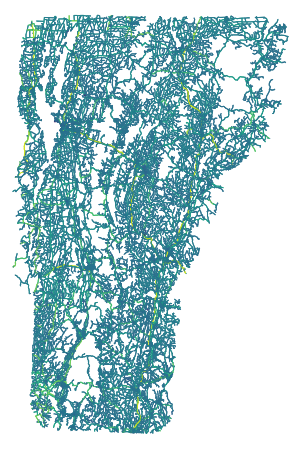

In [30]:
# calculate a color scheme for edges based on speed
ec = ox.plot.get_edge_colors_by_attr(G, attr="speed_kph", cmap='viridis')

# plot edge speeds
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, bgcolor="white")

# note: the aesthetics of this could be improved!

The graph of speed limits looks accurate, with local roads at low speeds and state and federal highways at higher speeds.

## "Helper" Functions

These functions are called when the model is run. 

### pharmacy_setting

Finds the nearest network node for each pharmacy.

Args:

* pharmacies: GeoDataFrame of pharmacies
* G: OSMNX network

Returns:

* GeoDataFrame of pharmacies with info on nearest network node

In [14]:
def pharmacy_setting(pharmacies, nodes):
    
    join = gpd.sjoin_nearest(pharmacies, nodes, distance_col="distances")
    
    #rename column from osmid to nearest_osm, so that it works with other code
    join = join.rename(columns={"osmid": "nearest_osm"})
    
    ## Some reformatting to get the GDF to look like it did before ##
    # Drop columns
    columns_to_drop = ['index_right', 'x', 'y', 'highway', 'ref', 'distances']
    join = join[join.columns[~join.columns.isin(columns_to_drop)]]

    return(join)


### pop_centroid

Converts geodata (population at county subdivision level) to centroids

Args:

* pop_df: a GeodataFrame of all population data
* pop_type: a string, either "pop" for at-risk population over 50 years old, or "covid" for COVID-19 case data

Returns:

* GeoDataFrame of centroids with population data. Three columns: code, pop, and geometry. Geometry is the centroid of each population. 

In [ ]:
def pop_centroid(pop_df):

    pop_df = pop_df.to_crs({'init': 'epsg:6589'}) #VT State plane EPSG
    
    # replace the geometry with its centroid
    pop_df["geometry"] = pop_df["geometry"].centroid
    
    # rename columns
    pop_df = pop_data.rename(columns={"GEOID": "code", "total_pop": "pop"})
    
    # keep only code, pop, and geometry columns
    pop_data = pop_data[["code", "pop", "geometry"]]
    
    return(pop_data)

### djikstra_cca_polygons

Function written by Joe Holler + Derrick Burt. A more efficient way to calculate distance-weighted catchment areas for each hospital in Holler et al. (2022). We use this method to calculate catchment areas for each pharmacy.  First, create a dictionary (with a node and its corresponding drive time from the hospital) of all nodes within a 30 minute drive time (using networkx single_cource_dijkstra_path_length function). From here, two more dictionaries are constructed by querying the original one. From these dictionaries, single part convex hulls are created for each drive time interval and appended into a single list (one list with 3 polygon geometries). Within the list, the polygons are differenced from each other to produce three catchment areas.

Args:
* G: cleaned network graph *with node point geometries attached*
* nearest_osm: A unique nearest node ID calculated for a single pharmacy
* distances: 3 distances (in drive time) to calculate catchment areas from
* distance_unit: unit to calculate (time)

Returns:
* A list of 3 differenced (not-overlapping) catchment area polygons (10 min poly, 20 min poly, 30 min poly)

In [33]:
def dijkstra_cca_polygons(G, nearest_osm, distances, distance_unit = "travel_time"):
    
    ## Distance_unit is given in seconds ##
    
    ## CREATE DICTIONARIES ##
    # create dictionary of nearest nodes
    nearest_nodes_30 = nx.single_source_dijkstra_path_length(G, nearest_osm, distances[2], distance_unit) # creating the largest graph from which 10 and 20 minute drive times can be extracted from
    
    # extract values within 20 and 10 (respectively) minutes drive times
    nearest_nodes_20 = dict()
    nearest_nodes_10 = dict()
    for key, value in nearest_nodes_30.items():
        if value <= distances[1]:
            nearest_nodes_20[key] = value
        if value <= distances[0]:
            nearest_nodes_10[key] = value
    
    ## CREATE POLYGONS FOR 3 DISTANCE CATEGORIES (10 min, 20 min, 30 min) ##
    
    # 30 MIN
    # If the graph already has a geometry attribute with point data,
    # this line will create a GeoPandas GeoDataFrame from the nearest_nodes_30 dictionary
    points_30 = gpd.GeoDataFrame(gpd.GeoSeries(nx.get_node_attributes(G.subgraph(nearest_nodes_30), 'geometry')))

    # This line converts the nearest_nodes_30 dictionary into a Pandas data frame and joins it to points
    # left_index=True and right_index=True are options for merge() to join on the index values
    points_30 = points_30.merge(pd.Series(nearest_nodes_30).to_frame(), left_index=True, right_index=True)

    # Re-name the columns and set the geodataframe geometry to the geometry column
    points_30 = points_30.rename(columns={'0_x':'geometry','0_y':'z'}).set_geometry('geometry')

    # Create a convex hull polygon from the points
    polygon_30 = gpd.GeoDataFrame(gpd.GeoSeries(points_30.unary_union.convex_hull))
    polygon_30 = polygon_30.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # 20 MIN # 1200 seconds!
    # Select nodes less than or equal to 20
    points_20 = points_30.query("z <= 1200")
    
    # Create a convex hull polygon from the points
    polygon_20 = gpd.GeoDataFrame(gpd.GeoSeries(points_20.unary_union.convex_hull))
    polygon_20 = polygon_20.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # 10 MIN # 600 seconds!
    # Select nodes less than or equal to 10
    points_10 = points_30.query("z <= 600")
    
    # Create a convex hull polygon from the points
    polygon_10 = gpd.GeoDataFrame(gpd.GeoSeries(points_10.unary_union.convex_hull))
    polygon_10 = polygon_10.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # Create empty list and append polygons
    polygons = []
    
    # Append
    polygons.append(polygon_10)
    polygons.append(polygon_20)
    polygons.append(polygon_30)
    
    # Clip the overlapping distance ploygons (create two donuts + hole)
    for i in reversed(range(1, len(distances))):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")

    return polygons

### pharmacy_measure_acc (adjusted to incorporate dijkstra_cca_polygons)

Measures the effect of a single pharmacy on the surrounding area. (Uses `dijkstra_cca_polygons`)

Args:

* \_thread\_id: int used to keep track of which thread this is
* hospital: Geopandas dataframe with information on a pharmacy
* pop_data: Geopandas dataframe with population data
* distances: Distances in time to calculate accessibility 
* weights: how to weight the different travel distances

Returns:

* Tuple containing:
    * Int (\_thread\_id)
    * GeoDataFrame of catchment areas with key stats

In [15]:
def pharmacy_measure_acc (_thread_id, pharmacies, pop_df, distances, weights):
    
    # Create polygons
    polygons = dijkstra_cca_polygons(G, hospital['nearest_osm'], distances)
    
    # iterate over pop_data and check if each point is within a polygon
    # if so, multiply the pop and weight for that polygon and appends it to num_pops. 
    num_pops = []
    for j in pop_data.index:
        point = pop_data['geometry'][j]
        # Multiply polygons by weights
        for k in range(len(polygons)):
            if len(polygons[k]) > 0: # To exclude the weirdo (convex hull is not polygon)
                if (point.within(polygons[k].iloc[0]["geometry"])):
                    num_pops.append(pop_data['pop'][j]*weights[k])  
    
    # sum all the weighted populations
    total_pop = sum(num_pops)
    
    # update polygons with time, total population, and ICU beds. Set CRS to 4326, then convert to 32616
    for i in range(len(distances)):
        polygons[i]['time']=distances[i]
        polygons[i]['total_pop']=total_pop
        polygons[i]['hospital_icu_beds'] = float(hospital['Adult ICU'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i].crs = { 'init' : 'epsg:4326'}
        polygons[i] = polygons[i].to_crs({'init':'epsg:32616'})
    
    # print the thread ID
    print('{:.0f}'.format(_thread_id), end=" ", flush=True)
    
    # return a tuple containing the thread ID and a list of copied polygons
    return(_thread_id, [ polygon.copy(deep=True) for polygon in polygons ]) 

### measure_acc_par

Parallel implementation of accessibility measurement.

Args:

* hospitals: Geodataframe of hospitals
* pop_data: Geodataframe containing population data
* network: OSMNX street network
* distances: list of distances to calculate catchments for
* weights: list of floats to apply to different catchments
* num\_proc: number of processors to use.

Returns:

* Geodataframe of catchments with accessibility statistics calculated

In [ ]:
def measure_acc_par (hospitals, pop_data, network, distances, weights, num_proc = 4):
    
    # initialize catchment list, 3 empty geodataframes
    catchments = []
    for distance in distances:
        catchments.append(gpd.GeoDataFrame())
        
    # pool = mp.Pool(processes = num_proc)
    
    # makes a list of all hospital info.  len = 66
    # looks like this, except with all info, and for all 66 hospitals
    # [[2, Methodist Hospital of Chicago, Chicago], [4, Advocate Christ Medical Center, Oak Lawn]]
    hospital_list = [ hospitals.iloc[i] for i in range(len(hospitals)) ]
    
    print("Calculating", len(hospital_list), "hospital catchments...\ncompleted number:", end=" ")
    
    # call hospital_acc_unpacker
    # returns a tuple containing the thread ID and a list of copied polygons
    #results = pool.map(hospital_acc_unpacker, zip(range(len(hospital_list)), hospital_list, itertools.repeat(pop_data), itertools.repeat(distances), itertools.repeat(weights)))
    
    results = []  
    for i in range(len(hospital_list)): #do from 1 to 66
        result = hospital_measure_acc(i, hospital_list[i], pop_data, distances, weights)
        results.append(result)

    # pool.close()
    
    # sort and extract the results
    results.sort()
    results = [ r[1] for r in results ]
    
    # combine catchment results into the respective GeoDataFrames in the catchments list
    for i in range(len(results)):
        for j in range(len(distances)):
            catchments[j] = catchments[j].append(results[i][j], sort=False)
            
    return catchments

### overlapping_function

Calculates how all catchment areas overlap with and affect the accessibility of each grid in our grid file.

Args:

* grid_file: GeoDataFrame of our grid
* catchments: GeoDataFrame of our catchments
* service_type: the kind of care being provided (ICU beds vs. ventilators)
* weights: the weight to apply to each service type
* num\_proc: the number of processors

Returns:

* Geodataframe - grid\_file with calculated stats

In [ ]:
def overlapping_function (grid_file, catchments, service_type, weights, num_proc = 4):

    ## Area Weighted Reaggregation
        # set weighted to False for original 50% threshold method
        # switch to True for area-weighted overlay
    weighted = True

    # if the value to be calculated is already in the hegaxon grid, delete it
    # otherwise, the field name gets a suffix _1 in the overlay step
    if resource in list(grid_file.columns.values):
        grid_file = grid_file.drop(resource, axis = 1)

    # calculate hexagon 'target' areas
    grid_file['area'] = grid_file.area

    # Intersection overlay of hospital catchments and hexagon grid
    print("Intersecting hospital catchments with hexagon grid...")
    fragments = gpd.overlay(grid_file, geocatchments, how='intersection')

    # Calculate percent coverage of the hexagon by the hospital catchment as
    # fragment area / target(hexagon) area
    fragments['percent'] = fragments.area / fragments['area']

    # if using weighted aggregation... 
    if weighted:
        print("Calculating area-weighted value...")
        # multiply the service/population ratio by the distance weight and the percent coverage
        fragments['value'] = fragments[resource] * fragments['weight'] * fragments['percent']

    # if using the 50% coverage rule for unweighted aggregation...
    else:
        print("Calculating value for hexagons with >=50% overlap...")
        # filter for only the fragments with > 50% coverage by hospital catchment
        fragments = fragments[fragments['percent']>=0.5]
        # multiply the service/population ration by the distance weight
        fragments['value'] = fragments[resource] * fragments['weight']

    # select just the hexagon id and value from the fragments,
    # group the fragments by the (hexagon) id,
    # and sum the values
    print("Summarizing results by hexagon id...")
    sum_results = fragments[['id', 'value']].groupby(by = ['id']).sum()

    # join the results to the hexagon grid_file based on hexagon id
    print("Joining results to hexagons...")
    results = pd.merge(grid_file, sum_results, how="left", on = "id")

    # rename value column name to the resource name 
    return(results.rename(columns = {'value' : resource}))

### normalization

Normalizes our result (Geodataframe).

In [ ]:
def normalization (result, resource):
    result[resource]=(result[resource]-min(result[resource]))/(max(result[resource])-min(result[resource]))
    return result

### file_import

Imports all files we need to run our code and pulls the Illinois network from OSMNX if it is not present (will take a while). 

**NOTE:** even if we calculate accessibility for just Chicago, we want to use the Illinois network (or at least we should not use the Chicago network) because using the Chicago network will result in hospitals near but outside of Chicago having an infinite distance (unreachable because roads do not extend past Chicago).

Args:

* pop_type: population type, either "pop" for general population or "covid" for COVID-19 cases
* region: the region to use for our hospital and grid file ("Chicago" or "Illinois")

Returns:

* G: OSMNX network
* hospitals: Geodataframe of hospitals
* grid_file: Geodataframe of grids
* pop_data: Geodataframe of population

In [ ]:
def output_map(output_grid, base_map, hospitals, resource):
    ax=output_grid.plot(column=resource, cmap='PuBuGn',figsize=(18,12), legend=True, zorder=1)
    # Next two lines set bounds for our x- and y-axes because it looks like there's a weird 
    # Point at the bottom left of the map that's messing up our frame (Maja)
    ax.set_xlim([314000, 370000])
    ax.set_ylim([540000, 616000])
    base_map.plot(ax=ax, facecolor="none", edgecolor='gray', lw=0.1)
    hospitals.plot(ax=ax, markersize=10, zorder=1, c='blue')

## Run the model

Below you can customize the input of the model:

* Processor - the number of processors to use
* Population - the population to calculate the measure for
* Resource - the hospital resource of interest
* Hospital - all hospitals or subset to check code

### Process population data

In [ ]:
''' 
To simplify the reanalysis, in variables I will hardcode the use of 
    4 processors
    Population: Population at Risk
    Resource: ICU Beds
    Hospital: All hospitals
'''

resource = "hospital_icu_beds"
num_proc = 4
pop_type = "pop"

## Create centroids for atrisk population at the census tract level
pop_data = pop_centroid(atrisk_data, pop_type)    
    
distances = [600, 1200, 1800] # Distances in travel time (seconds!)
weights = [1.0, 0.68, 0.22] # Weights where weights[0] is applied to distances[0]

In [ ]:
pop_data

### Process hospital data

In [ ]:
hospitals

In [ ]:
#Finds the nearest network node for each hospital
hospitals = hospital_setting(hospitals, nodes)

In [ ]:
hospitals


### Visualize catchment areas for hospital #4

In [ ]:
# Create point geometries for entire graph

# which hospital to visualize? 
fighosp = 4

# Create catchment for hospital 4
poly = dijkstra_cca_polygons(G, hospitals['nearest_osm'][fighosp], distances)

# Reproject polygons
for i in range(len(poly)):
    poly[i].crs = { 'init' : 'epsg:4326'}
    poly[i] = poly[i].to_crs({'init':'epsg:32616'})

# Reproject hospitals 
hospital_subset = hospitals.iloc[[fighosp]].to_crs(epsg=32616)

fig, ax = plt.subplots(figsize=(12,8))

min_10 = poly[0].plot(ax=ax, color="royalblue", label="10 min drive")
min_20 = poly[1].plot(ax=ax, color="cornflowerblue", label="20 min drive")
min_30 = poly[2].plot(ax=ax, color="lightsteelblue", label="30 min drive")

hospital_subset.plot(ax=ax, color="red", legend=True, label = "hospital")

# Add legend
ax.legend()

### Calculate hospital catchment areas

In [ ]:
%%time

catchments = measure_acc_par(hospitals, pop_data, G, distances, weights, num_proc)

### Calculate accessibility

### Post-process the catchments (for area weighted reaggregation)

In [ ]:
# add weight field to each catchment polygon
for i in range(len(weights)):
    catchments[i]['weight'] = weights[i]
# combine the three sets of catchment polygons into one geodataframe
geocatchments = pd.concat([catchments[0], catchments[1], catchments[2]])
geocatchments

### Area Weighted Reaagregation

In [ ]:
%%time
result = overlapping_function(grid_file, catchments, resource, weights, num_proc)

In [ ]:
%%time
result = normalization (result, resource)

## Results & Discussion

Extensive cleaning of unneccesary variables and lines of code that were never called.

### Making code more efficient and easier to read with GeoPandas

1. Made the __pop_centroid__ function much faster - preciosly took 3:30 to run, now less than a second. Instead of creating an empty GDF and iterating over all of the population geometries, adding data to this new GDF, I just used the native GeoPandas centroid method, replacing the population geometries with centroids, and then dropping other unnecessary columns from atrisk_data. 

2. Rewrote the __hospital_setting__ function to find each hospital's nearest node using GeoPandas nearest join method. What took 1:20 to run now runs in less than a second. I also cleaned the GDF so that it matched what we were working with before. 

### Removed parallel processing from two functions. 

1. __overlapping_function__
2. __measure_acc_par__

### Theoretical Changes to the methodology

Area weighted reaggregation - 
assigned speeds to the road network using osnmx. 

### Simplifying Code for future students

My greatest contribution to this replication has been the simplification of code and adding documentation to functions. This has made the code much easier for future students to read through and understand, and has not sacrificed processing times. I also made a visual workflow, visualizing the replication study from start to finish, including all data and functions used to manipulate them. 

Simplifications include:

I removed the dropdown menu that allows you to choose between population groups and hospital data. The benefits of this dropdown options were minimal, and it just made the code more confusing to follow and modify. In the form of a dropdown selection, it prevents the study from being one script, and introduces potential error as groups try to replicate eachother, if they are not clear about which choices they made with their mouse in the dropdown. 

I was able to delete the function __overlap_calc__, after implementing its function into __overlapping_function__ which was implements the area weighted reaggregation.

I removed a code block that filtered rows where the "hospital_icu_beds" value is infinity, which did not do anything. 



### Accessibility Map

In [ ]:
%%time
hospitals = hospitals.to_crs({'init': 'epsg:26971'})
result = result.to_crs({'init': 'epsg:26971'})
output_map(result, pop_data, hospitals, resource)

Classified Accessibility Outputs

### Conclusion

to be written.

### References

Luo, W., & Qi, Y. (2009). An enhanced two-step floating catchment area (E2SFCA) method for measuring spatial accessibility to primary care physicians. Health & place, 15(4), 1100-1107.